In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
import os
import matplotlib.pyplot as plt
import json

/home/getz/PycharmProjects/CognitiveReflection/venv/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


# Data cleaning

In [38]:
def do_some_formatting(df, label, dataset):
    # set labels and exp correctly (different formatting a vs answer for gpt and human)
    df['exp'] = label
    if 'answer' in df.columns:
        df['a'] = df['answer']
    # set lower case
    df['a'] = df['a'].str.lower()
    # remove why? 
    # df = df[df['q_id']==0]
    
    # format titles
    for i in df['item_id'].unique():
        cursor = 2
        if i in (1, 2):
            cursor = 0
            
        df.loc[df['item_id']==i, 'title'] = \
                str(dataset[dataset['id']==i]['title'].unique()[0])[cursor:]
        df.loc[df['item_id']==i, 'cond'] = \
                str(dataset[dataset['id']==i]['title'].unique()[0])[:cursor]
    
    return df

def add_principles(df):
    df['principle'] = ''
    df['principle'] = df['principle'].astype('object')
    df.loc[df['cond'].str.contains('ik|ci|fk|cf'), 'principle'] += ' action '
    df.loc[df['cond'].str.contains('l'), 'principle'] += ' inaction '
    df.loc[df['cond'].str.contains('f'), 'principle'] += ' foreseen '
    df.loc[df['cond'].str.contains('i'), 'principle'] += ' intended '
    df.loc[df['cond'].str.contains('c'), 'principle'] += ' contact '
    df.loc[~df['cond'].str.contains('c'), 'principle'] += ' no_contact '

    return df

def add_yes_no(df):
    df['yes'] = df['a'].str.contains(pat=r'\b(yes)\b', regex=True)
    df['no'] = df['a'].str.contains(pat=r'\b(no)\b', regex=True)
    df['unclear'] = df['yes'] == df['no']
    df['val'] = None
    df.loc[df['yes']==1, 'val'] = 'yes'
    df.loc[df['no']==1, 'val'] = 'no'
    df.loc[df['unclear']==1, 'val'] = 'unclear'
    return df

def mean_by_exp_and_sub(df):
    # set cond label and merge 
    exp = df['exp'].unique()
    dfs = []
    for e in exp:
        d = df[df['exp']==e].groupby(['title', 'principle' ], as_index=False).mean()
        d['exp'] = e
        dfs.append(d.copy())

    df2 = pd.concat(dfs)
    return df2

def exclude_based_on_unclear(df):
    # exclude based on unclear
    df = df[df['unclear']==False]
    return df

def exclude_based_on_control(df, human=True):
    controls = df[df.item_id.isin([1,2])]
    # print(controls) 
    col = 'prolific_id'
    if not human:
        col = 'iter'
        
    to_exclude = \
    (controls[(controls['title']=='sControl') & (controls['val']!='yes')][col].unique().tolist()
    + controls[(controls['title']=='hControl') & (controls['val']!='no')][col].unique().tolist())
    
    print('exp: ', df['exp'].unique()[0])
    print('total excluded based on controls: ', len(to_exclude))
    for i in to_exclude:
        print('excluding ', i)

    # remove subject
    df2 = df[~df[col].isin(to_exclude)]
    # remvove control trials
    df2 = df2[~df2.item_id.isin([1,2])]
    return df2


# set folder names and filenames
foldernames = [
    './GPT3/cushman/items-07_07_2022__19:58:42',
    './GPT3/cushman/items-003_2023',
    './HUMANS/',
]
filenames = ['/results.csv', '/results.csv', '/cushman.csv']
labels = ['gpt-002', 'gpt-003', 'human']
dfs = []
dfs_with_unclear = []

# load dataset
dataset = json.load(open('data/cushman/items.json'))
dataset = pd.DataFrame(dataset)

for label, foldername, fname in zip(labels, foldernames, filenames):
    df = pd.read_csv(open(foldername+fname, 'r', encoding='utf-8-sig', errors='replace'))
    # remove control
    df = do_some_formatting(df.copy(), label, dataset)
    df = add_principles(df.copy())
    df = add_yes_no(df.copy())
    # df = exclude_based_on_control(df.copy(), human=label=='human')
    dfs_with_unclear.append(df.copy())
    df = df[df['unclear']!=1] 
    dfs.append(df.copy())
    
df = pd.concat(dfs)
df_with_unclear = pd.concat(dfs_with_unclear)

df2 = mean_by_exp_and_sub(df)
df2_with_unclear = mean_by_exp_and_sub(df_with_unclear)

    
df[df['val']=='unclear'].to_excel(foldername[0] + '/unclear.xlsx')
print('unclear proportion: ', np.mean(df_with_unclear[df_with_unclear.exp=='human']['unclear']==1))

df_with_unclear

/tmp/ipykernel_93414/2675282477.py:37: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['yes'] = df['a'].str.contains(pat=r'\b(yes)\b', regex=True)
/tmp/ipykernel_93414/2675282477.py:38: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['no'] = df['a'].str.contains(pat=r'\b(no)\b', regex=True)


unclear proportion:  0.5060422960725075


,Unnamed: 0,item_id,question,q_id,iter,a_id,a,exp,title,cond,principle,yes,no,unclear,val,prolific_id,item_idx,answer,rt,time
0,0.0,1,Adam is driving his motorboat when he notices ...,0,0.0,0,"\nyes, accelerating quickly is the right thing...",gpt-002,sControl,,no_contact,True,False,False,yes,NaN,NaN,NaN,NaN,NaN
1,1.0,1,Why?,1,0.0,1,\n\nbecause if adam does not drive toward them...,gpt-002,sControl,,no_contact,False,False,True,unclear,NaN,NaN,NaN,NaN,NaN
2,2.0,1,Adam is driving his motorboat when he notices ...,0,1.0,0,"\nyes, accelerating quickly is the right thing...",gpt-002,sControl,,no_contact,True,False,False,yes,NaN,NaN,NaN,NaN,NaN
3,3.0,1,Why?,1,1.0,1,\n\nbecause if adam does not drive toward the ...,gpt-002,sControl,,no_contact,False,False,True,unclear,NaN,NaN,NaN,NaN,NaN
4,4.0,1,Adam is driving his motorboat when he notices ...,0,2.0,0,"\nyes, accelerating quickly is the right thing...",gpt-002,sControl,,no_contact,True,False,False,yes,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1981,NaN,12,Why?,1,NaN,1,would cause an obvious death.,human,Speed,ik,action intended no_contact,False,False,True,unclear,5ea07fc202b8bd05bb59bc38,29.0,Would cause an obvious death.,53230.0,2022-09-21 20:27:08
1982,NaN,27,Ed is driving five sick people to the hospital...,0,NaN,0,yes,human,Car,fk,action foreseen no_contact,True,False,False,yes,5ea07fc202b8bd05bb59bc38,30.0,Yes,70009.0,2022-09-21 20:28:18
1983,NaN,27,Why?,1,NaN,1,complete the plan to save 5. many more obstacl...,human,Car,fk,action foreseen no_contact,False,False,True,unclear,5ea07fc202b8bd05bb59bc38,30.0,Complete the plan to save 5. Many more obstacl...,70009.0,2022-09-21 20:28:19
1984,NaN,2,Ben sees that an empty runaway boxcar is heade...,0,NaN,0,no,human,hControl,,no_contact,False,True,False,no,5ea07fc202b8bd05bb59bc38,31.0,no,103497.0,2022-09-21 20:30:02


# Fig 1

In [25]:
#d = []
#pairs = [('action', 'inaction'), ('intended', 'foreseen'), ('contact', 'no_contact')]
#labels = ('action', 'intention', 'contact')
#titles = [
#    ('Boxcar', 'Pond', 'Ship', 'Car', 'Boat', 'Switch'),
#    ('Speed', 'Burn', 'Boxcar', 'Switch', 'Chem', 'Shark'),
#    ('Speed', 'Boxcar', 'Aqua', 'Rubble')
#]
#for p,l,t1 in zip(pairs, labels, titles):
#    for t in t1:
#        d.append({
#            'principle': p[0],
#            'item': t,
#            'yes': df2.loc[(df2['title'] == t) * (df2['principle'].str.contains(' ' + p[0] + ' ')), 'yes'].mean()
#        })
#        d.append({
#               'principle': p[1],
#               'item': t,
#               'yes': df2.loc[(df2['title'] == t) * (df2['principle'].str.contains(' ' + p[1] + ' ')), 'yes'].mean()
#        })
#
#
#new_df = pd.DataFrame(d)
#new_df
#
#d = []
#
#for p,l,t1 in zip(pairs, labels, titles):
#    for t in t1:
#        d.append(
#            {
#                'principle': p[0],    
#                'item': t,
#                'replicates': df2.loc[(df2['title'] == t) * (df2['principle'].str.contains(' ' + p[1] + ' ')), 'yes'].mean() >\
#                            df2.loc[(df2['title'] == t) * (df2['principle'].str.contains(' ' + p[0] + ' ')), 'yes'].mean()
#
#            }
#        )
#df_table = pd.DataFrame(d)
#df_table.loc[df_table['principle'] == 'intended', 'principle'] = 'intention'
#print(df_table)
#
#
df2 = df
dv = 'yes'
d = []
pairs = [('action', 'inaction'), ('intended', 'foreseen'), ('contact', 'no_contact')]
labels = ('action', 'intention', 'contact')
titles = [
    ('Boxcar', 'Pond', 'Ship', 'Car', 'Boat', 'Switch'),
    ('Speed', 'Burn', 'Boxcar', 'Switch', 'Chem', 'Shark'),
    ('Speed', 'Boxcar', 'Aqua', 'Rubble')
]
for p,l,t1 in zip(pairs, labels, titles):
    for e in ['gpt-002', 'gpt-003', 'human']:
        df2 = df[df['exp']==e]

        if 'gpt' in e:
            key = 'iter'
            sub = df['iter'].unique()
        else:
            key = 'prolific_id'
            sub = df['prolific_id'].unique()


        for t in t1:
            for i in sub:
                if i in ['nan', np.NaN, 'notfound']:
                    continue


                d.append({
                    'principle': p[0],
                    'item': t,
                    'val': df2.loc[(df2[key] == i) * (df2['title'] == t) * (df2['principle'].str.contains(' ' + p[0] + ' ')), dv].mean(),
                    'meta_principle': l,
                    key: i,
                    'exp': e,
                })
                d.append({
                       'principle': p[1],
                       'item': t,
                       'val': df2.loc[(df2[key]==i) * (df2['title'] == t) * (df2['principle'].str.contains(' ' + p[1] + ' ')), dv].mean(),
                       'meta_principle': l,
                       key: i,
                        'exp': e,
                })


new_df = pd.DataFrame(d)

d = []

for p,l,t1 in zip(pairs, labels, titles):
    for e in ['gpt-002', 'gpt-003', 'human']:
        df2 = df[df['exp']==e]


        for t in t1:
            d.append(
                {
                    'principle': p[0],    
                    'item': t,
                    'replicates': df2.loc[(df2['title'] == t) * (df2['principle'].str.contains(' ' + p[1] + ' ')), dv].mean() >\
                                df2.loc[(df2['title'] == t) * (df2['principle'].str.contains(' ' + p[0] + ' ')), dv].mean(),
                                'exp': e,

                }
            )
df_table = pd.DataFrame(d)
df_table.loc[df_table['principle'] == 'intended', 'principle'] = 'intention'
print(df_table)
print(new_df)

    principle    item  replicates      exp
0      action  Boxcar       False  gpt-002
1      action    Pond       False  gpt-002
2      action    Ship       False  gpt-002
3      action     Car        True  gpt-002
4      action    Boat       False  gpt-002
5      action  Switch       False  gpt-002
6      action  Boxcar       False  gpt-003
7      action    Pond       False  gpt-003
8      action    Ship       False  gpt-003
9      action     Car       False  gpt-003
10     action    Boat       False  gpt-003
11     action  Switch       False  gpt-003
12     action  Boxcar       False    human
13     action    Pond        True    human
14     action    Ship        True    human
15     action     Car        True    human
16     action    Boat        True    human
17     action  Switch       False    human
18  intention   Speed       False  gpt-002
19  intention    Burn        True  gpt-002
20  intention  Boxcar        True  gpt-002
21  intention  Switch        True  gpt-002
22  intenti

# Fig 1

/tmp/ipykernel_93414/481418543.py:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pg.ttest(x=df3[df3.principle_variation=='yes'][df3.meta_principle=='contact']['val'], y=df3[df3.principle_variation=='no'][df3.meta_principle=='contact']['val'], paired=True)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.43741,26,two-sided,0.021941,"[-0.25, -0.02]",0.367944,2.422,0.452791


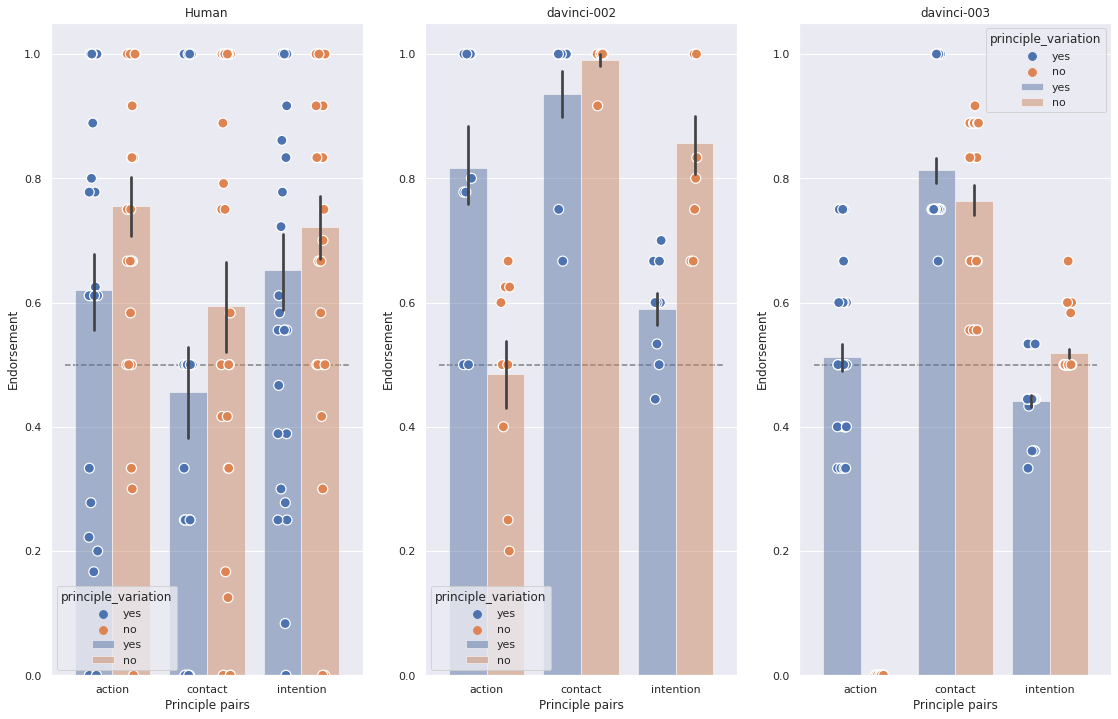

In [27]:
sns.set(rc={'figure.figsize':(19, 12)})

plt.subplot(1, 3, 1)
df3 = new_df[new_df.exp=='human'].groupby(['principle', 'prolific_id', 'meta_principle'], as_index=False).mean()
df3['principle_variation'] = 'yes'
df3.loc[df3['principle'].isin(['no_contact', 'foreseen', 'inaction']), 'principle_variation'] = 'no'
sns.stripplot(x='meta_principle', y='val', hue='principle_variation', data=df3, size=10, linewidth=1.2, zorder=2, edgecolor='white', dodge=True)
sns.barplot(x='meta_principle', y='val', hue='principle_variation', ci=68,data=df3, alpha=.5, zorder=1, dodge=True)
# raincloud(x='exp', y='yes', markersize=9, df=df2)
x_lim = plt.gca().get_xlim()
plt.plot(x_lim, [.5, .5], ls='--', color='gray', zorder=0)
# plt.ylim(0.5,1.5)
plt.xlabel('Principle pairs')
plt.ylabel('Endorsement')
plt.title('Human')


plt.subplot(1, 3, 2)
df3 = new_df[new_df.exp=='gpt-002'].groupby(['principle', 'iter', 'meta_principle'], as_index=False).mean()
df3['principle_variation'] = 'yes'
df3.loc[df3['principle'].isin(['no_contact', 'foreseen', 'inaction']), 'principle_variation'] = 'no'
sns.stripplot(x='meta_principle', y='val', hue='principle_variation', data=df3, size=10, linewidth=1.2, zorder=2, edgecolor='white', dodge=True)
sns.barplot(x='meta_principle', y='val', hue='principle_variation', data=df3, alpha=.5, zorder=1, ci=68, dodge=True)
# raincloud(x='exp', y='yes', markersize=9, df=df2)
x_lim = plt.gca().get_xlim()
plt.plot(x_lim, [.5, .5], ls='--', color='gray', zorder=0)
# plt.ylim(0.5,1.5)
plt.xlabel('Principle pairs')
plt.ylabel('Endorsement')
plt.title('davinci-002')

plt.subplot(1, 3, 3)
df3 = new_df[new_df.exp=='gpt-003'].groupby(['principle', 'iter', 'meta_principle'], as_index=False).mean()
df3['principle_variation'] = 'yes'
df3.loc[df3['principle'].isin(['no_contact', 'foreseen', 'inaction']), 'principle_variation'] = 'no'
sns.stripplot(x='meta_principle', y='val', hue='principle_variation', data=df3, size=10, linewidth=1.2, zorder=2, edgecolor='white', dodge=True)
sns.barplot(x='meta_principle', y='val', hue='principle_variation', data=df3, alpha=.5, zorder=1, ci=68, dodge=True)
# raincloud(x='exp', y='yes', markersize=9, df=df2)
x_lim = plt.gca().get_xlim()
plt.plot(x_lim, [.5, .5], ls='--', color='gray', zorder=0)
# plt.ylim(0.5,1.5)
plt.xlabel('Principle pairs')
plt.ylabel('Endorsement')
plt.title('davinci-003')




df3 = new_df[new_df.exp=='human'].groupby(['principle', 'prolific_id', 'meta_principle'], as_index=False).mean()
df3['principle_variation'] = 'yes'
df3.loc[df3['principle'].isin(['no_contact', 'foreseen', 'inaction']), 'principle_variation'] = 'no'

pg.ttest(x=df3[df3.principle_variation=='yes'][df3.meta_principle=='contact']['val'], y=df3[df3.principle_variation=='no'][df3.meta_principle=='contact']['val'], paired=True)


In [ ]:
sns.set(rc={'figure.figsize':(14, 8)})

order = ['action', 'inaction', 'intended', 'foreseen', 'contact', 'no_contact']
df3 = new_df.groupby(['principle', 'item'], as_index=False).mean()

sns.stripplot(x='principle', y='val', hue='item', data=df3,
    size=10, linewidth=1.2, zorder=2, edgecolor='white', dodge=True, order=order)

g = sns.barplot(x='principle', y='val', hue='item', data=df3,
    alpha=.5, zorder=1, ci=68, dodge=True, order=order,)

# s.legend_.show()
# raincloud(x='exp', y='yes', markersize=9, df=df2)
x_lim = plt.gca().get_xlim()
plt.plot(x_lim, [.5, .5], ls='--', color='gray', zorder=0)
# plt.ylim(0.5,7.5)
plt.xlabel('Principle')
plt.ylabel('Endorsement')

h, l = g.get_legend_handles_labels()
plt.legend(h[:12], l[:12], loc='lower right')


In [ ]:

def f(s, v, props): return np.where(s.isin([v]), props, '')
s = df_table.style
df_table1 = df_table[df_table['exp'] == 'human']
df_table1.loc[df_table1['replicates']==True, 'replicates'] = '✅'
df_table1.loc[df_table1['replicates']==False, 'replicates'] = '❌'

df_table1
# s.apply(f, v=True, props="color: lightgreen;", axis=0)\
# .apply(f, v=False, props="color: white; background-color:pink", axis=0)
# df_table.style.apply(f, v=False, props="color:lightred;", axis=0)

In [ ]:
ddd = df[(df.exp=='human') & (df.title=='Car')& (df.principle.str.contains('action'))]
